In [1]:
import numpy as np
import glob
import os
from matplotlib import pyplot as pl

from mlp_backprop_momentum import MLP
import k_fold_cross_validation as cv

import scipy.io.wavfile as wav
from scikits.talkbox.features import mfcc

%matplotlib inline

## Preparing dataset
### Load and split files by classes

In [2]:
path = os.getcwd() + '/vowels'

VOWELS = glob.glob(path + '/*.wav')
assert len(VOWELS) > 0, ".wav files not found in " + path + " ! Please check the path"

FILES = {
    'natural_male': glob.glob(path + '/nam*.wav'),
    'natural_female': glob.glob(path + '/naf*.wav'),
    'natural_kid': glob.glob(path + '/nk*.wav'),
    'synth_male': glob.glob(path + '/sam*.wav'),
    'synth_female': glob.glob(path + '/saf*.wav'),
    'synth_kid': glob.glob(path + '/sk*.wav')
}

# number of coefficients used
MFCC_COEFFS = 13

### MFCC computation

In [3]:
def read_wav_files(files):
    """
    Get the sample rate and all data for each files
    :param files: an array of file paths (must be .wav files)
    :return: (rates, data)
    """
    n = len(files)
    data = []
    rates = np.zeros(n)
    for i in xrange(len(files)):
        rate, d = wav.read(files[i])
        rates[i] = rate
        data.append(d)
    return rates, data
        

def compute_mfcc(files):
    """
    Calculate Mel-frequency cepstral coefficients (MFCCs) for each files
    and use the coefficients mean to summarize each file. So each file gets
    a vector of 13 coefficients instead of having a matrice containing coefficients 
    for all windows.
    
    :param files: an array of file paths (must be .wav files)
    :return: an array of shape (num_files, 13)
    """
    num_files = len(files)
    sample_rates, data = read_wav_files(files)
    ceps_mean = np.zeros((num_files, MFCC_COEFFS))
    
    for i in xrange(0, num_files):
        ceps_i, _, _ = mfcc(data[i], fs=sample_rates[i])
        ceps_mean[i] = np.mean(ceps_i, axis=0)

    return ceps_mean


def create_dataset(gender_classes):
    """
    Creates a dataset for training.
    Note that the returned dataset is shuffled to prevent issues during
    training.
    
    :param gender_classes: an array of tuples [(gender_key, output_class),]
    :return: dataset: a 2D-array which has a shape of (num_files, num_coeffs + 1)
        num_files: is the total number of files
        num_coeffs: is the number of MFCC coefficient (see MFCC_COEFFS)
        and finally the output class is added a the end of each element of the dataset
    """
    dataset = []
    for input_gender, output_class in gender_classes:
        ceps = compute_mfcc(FILES[input_gender])
        for input_ceps in ceps:
            dataset.append(np.append(input_ceps, output_class))
    dataset = np.array(dataset)
    np.random.shuffle(dataset)
    return dataset

### MFCC Visualization

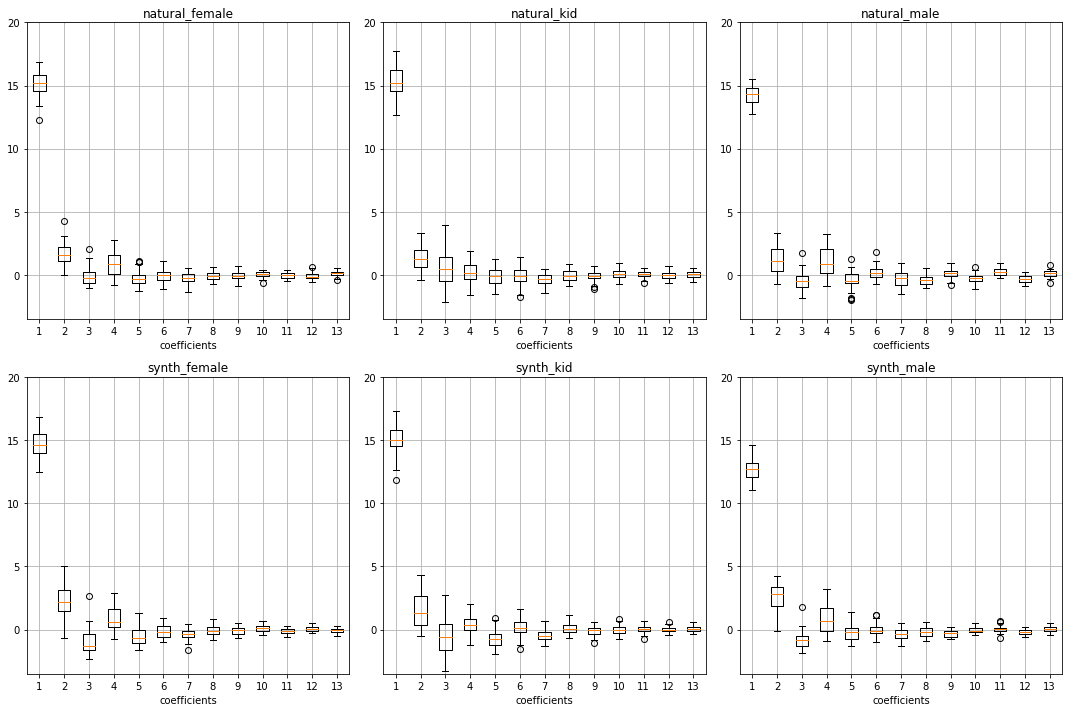

In [4]:
pl.figure(figsize=(15, 10))

NUM_PLOTS = len(FILES)
Y_MIN = -3.5
Y_MAX = 20
X_LABEL = 'coefficients'

for plot_index, s_class in enumerate(sorted(FILES.keys())):
    values = compute_mfcc(FILES[s_class])
    pl.subplot(2, 3, plot_index + 1)
    pl.ylim(Y_MIN, Y_MAX)
    pl.boxplot(values)
    pl.title(s_class)
    pl.xlabel(X_LABEL)
    pl.grid()
    
pl.tight_layout()

## MAN vs. WOMAN

Here we use only the natural voices of men and women to train a neural network that recognizes the gender of the speaker.

### Model complexity and learning duration

In order to choose the correct learning duration and the modely complexity, we iterate over the number of epochs (`EPOCHS`) and number of hidden neurons (`N_NEURONS`).

In [5]:
N_INITS = 10
EPOCHS = 1000
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5
N_TRAIN_FILES = 20

dataset = create_dataset([('natural_male', -1), ('natural_female', 1)])
dataset_input = dataset[:, :-1]     # filter only input values (n-1 first values)
dataset_output = dataset[:, -1:]    # filter only the output class (last value)

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
for index, n_neurons in enumerate(N_NEURONS):
    print 'testing', n_neurons, 'neurons...'
    nn = MLP([MFCC_COEFFS, n_neurons, 1], 'tanh')

    for i in np.arange(N_INITS):
        nn.init_weights()
        MSE[index, i, :] = nn.fit((dataset_input, dataset_output),
                                  learning_rate=LEARNING_RATE,
                                  momentum=MOMENTUM,
                                  epochs=EPOCHS)

testing 2 neurons...


testing 4 neurons...


testing 8 neurons...


Then we plot the result :

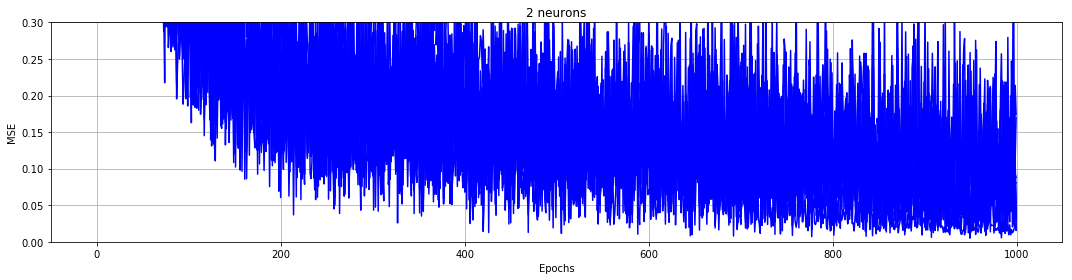

In [38]:
pl.figure(figsize=(15,4))

p_count = 0

for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)

    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    
    pl.ylim(0, 0.5)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()

pl.tight_layout()

### Final model and performance

In [9]:
EPOCHS = 500
K = 5

In [17]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))


dataset = []
for output, s_class in zip([-1, 1], ['natural_male', 'natural_female']):
    ceps = compute_mfcc(FILES[s_class])
    for input in ceps:
        dataset.append(np.append(input, output))

dataset = np.array(dataset)
np.random.shuffle(dataset)


for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = MLP([MFCC_COEFFS, h, 1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

Testing 2 neurons...


Testing 4 neurons...


Testing 8 neurons...


Testing 16 neurons...


Testing 32 neurons...


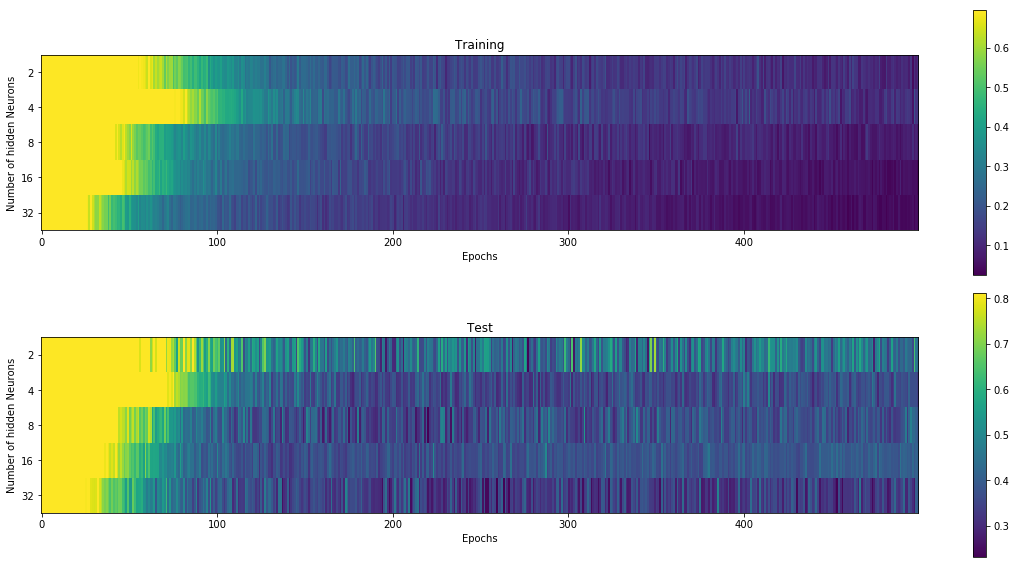

In [20]:
MAX_VAL = 90             # 100 is the maximum
pl.figure(figsize=(16, 8))
pl.subplot(2, 1, 1)
pl.imshow(MSE_train, vmin=np.min(MSE_train), vmax=np.percentile(MSE_train, 90), aspect=20, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2, 1, 2)
pl.imshow(MSE_test, vmin=np.min(MSE_test), vmax=np.percentile(MSE_test, 90), aspect=20, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

In [27]:
nn = MLP([MFCC_COEFFS, 4, 1], 'tanh')
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                           dataset,
                                                           k=5,
                                                           learning_rate=0.001,
                                                           momentum=0.5,
                                                           epochs=1000,
                                                           threshold=0.0)

print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
print conf_mat

NameError: name 'dataset' is not defined

In [43]:
success = 0
for d in dataset:
    pred = round(nn.predict(d[:13]), 0)
    label = d[13]
    if pred == label:
        success += 1
    else:
        print pred, "!=", label

print "precision",  success/float(dataset.shape[0])

0.0 != 1.0
precision 0.986111111111
